- **Nombre:** Francisco Javier Gañán Onieva

- **Correo:** fjganan14@gmail.com

- **DNI:** 77862083E

#### DECLARACIÓN JURADA

Afirmo que no he dado ni recibido ninguna ayuda no autorizada en este examen y que todo el trabajo ha sido mío. Cuando he utilizado un recurso no creado directamente por mí, he citado la fuente, y he descrito cómo la he utilizado.

He completado este examen de manera justa, honesta, respetuosa, responsable y confiable. Esto significa que he completado el examen como si el profesor
estuviera observando todas mis acciones. He actuado de acuerdo con las
instrucciones del profesor, y no he dado ni he recibido ninguna ayuda o asistencia que no sea la autorizada. Sé que la integridad de este examen y esta clase depende de mí, y me he comprometido a no tomar ninguna medida que rompa la confianza de mis compañeros de clase o profesor, o socave la equidad de esta clase.

Certifico que la escritura contenida en este documento es mía y que cualquier cita directa ha sido identificada y citada. Además, he citado referencias en cualquier lugar donde he tomado prestadas las ideas de otra persona.

#### Preparación del entorno

Se necesita clonar el siguiente repositorio de Github para poder realizar los pasos de este notebook.

In [46]:
!git clone https://github.com/javierganan99/EJERCICIO_PLN.git

Cloning into 'EJERCICIO_PLN'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 133 (delta 51), reused 55 (delta 27), pack-reused 53
Receiving objects: 100% (133/133), 43.17 MiB | 11.78 MiB/s, done.
Resolving deltas: 100% (64/64), done.


Vamos al directorio de trabajo.

In [47]:
%cd /content/EJERCICIO_PLN

/content/EJERCICIO_PLN


## Apartado 1

En este primer ejercicio se implementa la función *string addPunctuationBasic(string)* que, dado un string de entrada que contiene palabras en minísculas y sin signos de puntuación, devuelve dicho string con la primera letra en mayúsculas y un punto al final. Para mayor generalidad, se considera que la frase pueda contener espacios o tabulaciones al final, y si ya contiene un punto final no añadimos otro.


In [48]:
def addPunctuationBasic(sent):
    sent = sent[0].upper() + sent[1:]
    while sent[-1] == ' ' or sent[-1] == '\t' or sent[-1] == '\n':
        sent = sent[0:-1]
    if sent[-1] == '.' or sent[-1] == ',' or sent[-1] == '.' or sent[-1] == ':' or sent[-1] == ';' or sent[-1] == '?' or sent[-1] == '!':
        return sent
    else:
        return sent + '.'

addPunctuationBasic("i'm Francisco Javier Gañán")

"I'm Francisco Javier Gañán."

## Apartado 2

En este segundo apartado se implementa la función *[(pos, err)] verifyPunctuation(string test, string check)* . Esta función recibe como entrada dos strings y, basándose en la distancia de Levenshtein y en recorrer la matriz que se genera, calcula una lista para convertir *test* en *check*. Recorre la matriz inversamente generando una cadena que se corresponde con los fallos que cometió el modelo de puntuación, que no tiene por qué ser una de distancia mínima. Se puede encontrar información sobre este algoritmo para calcular la distancia de Levenshtein y la matriz asociada en https://sites.google.com/site/algoritmossimilaridaddistancia/distancia-de-levenshtein. 

En el modelo original de Levenshtein, que es el se usa en este apartado, cada operación de edición (inserción, sustitución o eliminación) tiene coste 1. Por tanto, la distancia de Levenshtein es la suma del número de ediciones realizadas. Needleman y Wunsch, en 1970, lo modificaron para permitir operaciones de edición con distinto costo. Sin embargo, esto no se considera en este ejercicio, ya que, en general, debería asignarse un costo personalizado a cada pareja de palabras para sustitución, eliminación e inserción. Además, para el caso de uso, se considera la misma penalización para cada fallo cometido por el modelo, ya sea sustitución, inserción o eliminación.

### Tokenizar

La siguiente función (*Tokenize*) se utiliza para tokenizar. Funciona tanto para frases individuales como para textos completos con numerosas frases. Se ha diseñado así para poder tokenizar correctamente los corpus utilizados en este ejercicio.

In [49]:
def Tokenize(seq):
        seqToken = [] # Guarda la secuencia tokenizada
        ant = 0 # Guarda la posición del carácter desde el que comienza un nuevo token
        punt_tuple = (".", ",", ":", ";", "?", "!")
        for i in range(len(seq)):
            if ant <= i:
                if seq[i] == ' ' and not (seq[i-1] in punt_tuple or seq[i-1] == ' ' or seq[i-1] == '\n'):    
                    seqToken.append(seq[ant:i])
                    ant = i + 1
                elif seq[i] == ' ':
                    ant = i + 1
                elif seq[i] in punt_tuple:
                    if ant < i:
                        seqToken.append(seq[ant:i])
                        seqToken.append(seq[i])
                        ant = i + 1
                    else:
                        seqToken.append(seq[i])
                        ant = i + 1
                elif i == len(seq) - 1 and seq[i] != '\n':
                    seqToken.append(seq[ant:i+1])

                elif seq[i].isnumeric():
                    j = i
                    while j < len(seq) and seq[j] != " ": #seq[j] in punt_tuple or seq[j].isnumeric():
                        j += 1
                    if seq[j-1] not in punt_tuple:
                        seqToken.append("$NUMERIC")
                    else:
                        seqToken.append("$NUMERIC")
                        seqToken.append(seq[j-1])
                    ant = j + 1
                # Para leer textos completos considerando el salto de línea. El salto de línea no se considera como token.
                # También se considera que el salto de línea se situa después de un signo de puntuación o de un espacio.
                if seq[i] == "\n":
                    ant = i + 1
                
        return seqToken

### Verificación de la puntuación

En la función *verifyPunctuation* se incluyen 3 funciones, que se ejecutan de forma consecutiva:

- **Tokenize**: La presentada en la celda anterior, para tokenizar los *strings* de entrada.

- **matrizLevenshtein**: Calcula la matriz cuyo último elemento (elemento de coordenadas la última fila y la última columna) es la distancia de Levenshtein. Esta matriz se utiliza para calcular posteriormente la lista de ediciones. 

- **ediciones**: Calcula la lista de ediciones recorriendo la matriz generada previamente, llamda **M**. **M** se recorre empezando en el último elemento. En cada iteración, mientras *i* y *j* (índices de la matriz de filas y columnas, respectivamente) no sean ambos iguales a 0:
    1. Se mira en la vecindad, donde *vecinos* = [**M**(*i -1*, *j*), **M**(*i*, *j - 1*), **M**(*i - 1*, *j - 1*)].
    2. Si el valor de algún vecino es igual a **M**(*i*,*j*), se actualizan *j = j - 1* y *i = i - 1*.
       Si no, se selecciona el valor mínimo de todos los vecinos, y se añade a la lista de ediciones la operación correspondiente (en función de las coordenadas del vecino de valor mínimo):

       - ( *i -1*, *j* ) -> ( 'D',*i* ): Se añade una eliminación a la lista de ediciones. Dicha eliminación se incluye en la lista junto con el índice *i*, que se corresponde con el *string* de *check* en este trabajo. 
       - ( *i*, *j - 1* ) -> ( 'I',*i* ): Se añade una inserción. 
       - ( *i -1*, *j - 1* ) -> ( 'S',*i* ): Se añade una sustitución.

       Si hay dos vecinos con valor mínimo, se comparan los tokens de ambas secuencias en la posición actual. En función de lo que haya ocurrido, se realiza el cambio correspondiente. Esta variante hace que no siempre se obtenga una secuencia de edición de distancia mínima, pero puede ocurrir que la secuencia correcta de edición no sea dicha distancia.

       Finalmente, se actualizan *i* y *j* con las coordenadas del vecino seleccionado.
        

Inspiración para **matrizLevenshtein**:
https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/

Inspiración para **ediciones**:
https://gist.github.com/curzona/9435822

In [52]:
import numpy as np
def verifyPunctuation(test, check):
    ## Primero se tokenizan las dos secuencias mediante la función Tokenize
    checkToken = Tokenize(check)
    testToken = Tokenize(test)
    punt_tuple = (".", ",", ":", ";", "?", "!")
            
    ## A continuación, se calcula la matriz que computa la distancia de Levenshtein
    def matrizLevenshtein(token1, token2):
        matrix = np.zeros((len(token1) + 1, len(token2) + 1)) # Se crea la matriz
        
        for t1 in range(len(token1) + 1): # La primera fila contiene los índices de las posiciones del token 1
            matrix[t1][0] = t1
        
        for t2 in range(len(token2) + 1): # La primera columna contiene los índices de las posiciones del token 2
            matrix[0][t2] = t2
        
        for t1 in range(1, len(token1) + 1):
            for t2 in range(1, len(token2) + 1):
                # Calcuate 
                if (token1[t1-1] == token2[t2-1]):
                    matrix[t1][t2] = matrix[t1 - 1][t2 - 1]
                else:
                    a = matrix[t1][t2 - 1]
                    b = matrix[t1 - 1][t2]
                    c = matrix[t1 - 1][t2 - 1]

                    if (a <= b and a <= c):
                        matrix[t1][t2] = a + 1
                    elif (b <= a and b <= c):
                        matrix[t1][t2] = b + 1
                    else:
                        matrix[t1][t2] = c + 1 

        return matrix
    matrix_L = matrizLevenshtein(checkToken,testToken)
    ## Se calcula la lista de ediciones
    def ediciones(token1, token2, mat):
        i,j = len(token1), len(token2)
        ediciones = []

        while(not (i==0 and j==0)):
            p = mat[i][j]
            vecinos = []

            if (i!=0 and j!=0):
                vecinos.append(mat[i-1][j-1])

            if (i!=0):
                vecinos.append(mat[i-1][j])
            
            if (j!=0):
                vecinos.append(mat[i][j-1])
            
            min_c = min(vecinos)

            if(min_c == p): # No se añadie ninguna edición
                i, j = i-1, j-1

            elif vecinos.count(min_c) > 1: # Si hay más de una posibilidad en los cambios
                if ( (token1[i-1] not in punt_tuple and token2[j-1] not in punt_tuple) or (token1[i-1] in punt_tuple and token2[j-1] in punt_tuple)) and i!=0 and j!=0:
                    i, j = i-1, j-1
                    ediciones.append(('S', i))
                elif token1[i-1] in punt_tuple and token2[j-1] not in punt_tuple and i!=0:
                    i, j = i-1, j
                    ediciones.append(('D', i))
                elif token1[i-1] not in punt_tuple and token2[j-1] in punt_tuple and j!= 0:
                    i, j = i, j-1
                    ediciones.append(('I', i))
                else:
                    print("Error")
                    return 0

            elif(j!=0 and min_c == mat[i][j-1]): # Si solo hay una posibilidad en los cambios, se selecciona
                i, j = i, j-1
                ediciones.append(('I', i))
            elif(i!=0 and j!=0 and min_c == mat[i-1][j-1]):
                i, j = i-1, j-1
                ediciones.append(('S', i))
            elif(i!=0 and min_c == mat[i-1][j]):
                i, j = i-1, j
                ediciones.append(('D', i))

        ediciones.reverse() # Como se ha recorrido la matriz a la inversa, se debe invertir la lista para que esté en el orden adecuado
        return ediciones

 
    return ediciones(checkToken, testToken, matrix_L) , testToken, checkToken

En la siguiente celda se proporcionan 3 ejemplos que verifican la validez de la función anterior, y se observa su comportamiento. Se corresponden, respectivamente, con la salida de un modelo de puntuación (*pred*) y con el *ground truth*. En las primeras dos frases, se puede observar como se genera una lista de ediciones que proporciona dos ediciones en la misma posición 15 (referida al check). Esto hace que la distancia de edición no sea mínima, pero los cambios son correctos. La segunda pareja se corresponde con la presentada en el enunciado del ejercicio. En la tercera, sin embargo, puede observarse un caso en el que no se generan las ediciones correctas para el final del check: "D.C.". Esto ocurre porque no se ha tokenizado "dc" como dos tokens, si no como uno, por lo que no es un fallo de la función de verificación.

In [51]:
# check = "Okay, well, the issue then is, do we need to be alive to see this kind of spontaneous order, and I've already hinted that the answer is no. "
# pred = "Okay well the issue then, Is do we need to be alive. To see this kind of spontaneous order and i've already hinted that the answer is no."

# check = "Hello. What’s your name?"
# pred = "Hello what’s your, name?"

check  = "He had the expectations of his senatorial father and Washington, D.C."
pred = "He had the expectations of his senatorial father and washington dc."

ediciones, b, c = verifyPunctuation(pred, check)

print(ediciones)
print(pred)


[('S', 9), ('D', 10), ('S', 11), ('D', 13), ('D', 14)]
He had the expectations of his senatorial father and washington dc.


## Apartado 3
 En este apartado se implementa una función (*calculaMetricas*) que calcula el rendimiento de un algoritmo de puntuación, evaluando su resultado en un corpus sobre el que se itera frase a frase. Las métricas que genera son Precisión, *Recall* y F1, para cada signo de puntuacioń considerado en este ejercicio. También se prueba dicha función para el algoritmo básico de puntuación del apartado 1 sobre el corpus de test.

In [7]:
## Guardamos los textos de test y check por líneas
f_test = open("datasets/PunctuationTask.test.en","r")
f_check = open("datasets/PunctuationTask.check.en","r")
linesTest = f_test.readlines()
linesCheck = f_check.readlines()
f_test.close()
f_check.close()

A continuación, se calculan las métricas correspondientes. Para ello, es necesario definir los conceptos de TP (*True Positives*), FP (*False Positives*) y FN (*False Negatives*) para un modelo de puntuación. Definimos:

-- **TP**: Cambios correctos que hace el modelo. Estos pueden ser, en general, para los modelos de puntuación que consideramos: Poner mayúscula, poner punto, poner coma, poner dos puntos, poner punto y coma, poner interrogación, poner exclamación. Es decir, añade el signo de puntuación correcto o la mayúscula donde debía realizarse dicho cambio.

-- **FP**: Cambios incorrectos que hace el modelo cuando no se debía hacer un cambio.

-- **FN**: Cambios que omite el modelo que deberían haberse realizado.

Estos valores se consideran para cada signo de puntuación.

Para calcular los TP, FP, FN, se genera la siguiente matriz de confusión.

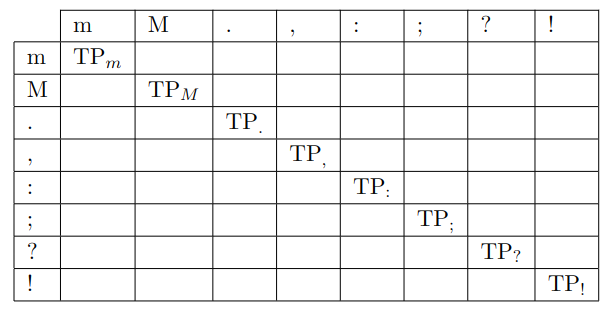


En ella, se van almacenando los diferentes valores para calcular las métricas, para todas las frases a evaluar. Los valores de la diagonal se corresponden con los **TP**. Las columnas con los **TP + FP** y las filas con los **TP + FN**. Es importante mencionar que no se pretende analizar el caso de las minúsculas, pues estas no se consideran como un cambio. Es decir, no se proporcionan métricas con respecto a este símbolo. Sin embargo, es importante añadirlas en la matriz, pues en las eliminaciones de símbolo (con respecto a la frase de *check*) o en las omisiones de mayúscula, la ausencia de cambio por parte del modelo se registrará, contemplándose dicho caso en la primera columna de la matriz. Además, si el modelo añade un símbolo o mayúscula y no se debía realizar ninguna acción, este se contempla en la primera fla.

In [64]:
import numpy as np
## Función para calcular las métricas
def calculaMetricas(linesTest, linesCheck, model):
    ## Iniciaizamos los valores de TP, FP, FN y la matriz de confusión
    confusion_m = np.zeros((8,8), dtype=int)
    punt_dict = {
    "m": 0, "M": 1, ".": 2, ",": 3, ":": 4, ";": 5, "?": 6, "!": 7
    }
    TP = [0] * 7
    TP_FP = [0] * 7
    TP_FN = [0] * 7
    for i, (line_test, line_check) in enumerate(zip(linesTest,linesCheck)):
        print(i/len(linesTest)) # Comentar si no se quiere controlar cuanto tiempo queda
        # Aplicamos el modelo de puntuacion
        modificado = model(line_test)
        cambios_finales, testToken, checkToken = verifyPunctuation(modificado,line_check)
        pos_finales = [c[1] for c in cambios_finales]
        cambios_necesarios  = verifyPunctuation(line_test,line_check)[0]

        correctos = [c for c in cambios_necesarios if c[1] not in pos_finales]
        for c in correctos:
            if c[0] == 'S' and checkToken[c[1]][0].isupper():
                confusion_m[punt_dict["M"] , punt_dict["M"]]  += 1 # Se ha colocado una mayúscula correctamente (se entiende que el test solo contiene minúsculas)
            else:
                if checkToken[c[1]] in punt_dict:
                    confusion_m[ punt_dict[checkToken[c[1]]] , punt_dict[checkToken[c[1]]] ] += 1 # Se ha insertado el signo correctamente
        
        offset = 0 # Porque los cambios están referidos al check
        for c in cambios_finales:
            if c[0] == 'S':

                if checkToken[c[1]][0].isupper(): key_c = "M"
                elif checkToken[c[1]] in punt_dict: key_c = checkToken[c[1]]
                else: key_c = "m"

                if testToken[c[1] + offset][0].isupper(): key_t = "M"
                elif testToken[c[1] + offset] in punt_dict: key_t = testToken[c[1] + offset]
                else: key_t = "m"
                
                if key_t == key_c:
                    continue # No se ha cometido un fallo de puntuación

                confusion_m[ punt_dict[key_c] , punt_dict[key_t] ] += 1 #[Valor real , Valor predicho]

            elif c[0] == 'D':
                if checkToken[c[1]] in punt_dict: # Se pone el if ya que en algunos casos la edición real no es la de distancia mínima
                    confusion_m[ punt_dict[checkToken[c[1]]] , punt_dict["m"] ] += 1 #[Valor real , Valor predicho]
                offset -= 1
                
            elif c[0] == 'I':
                if testToken[c[1] + offset] in punt_dict:
                    confusion_m[ punt_dict["m"] , punt_dict[testToken[c[1] + offset]] ] += 1 #[Valor real , Valor predicho]
                offset += 1

    for i in range(len(TP)):
        TP[i] = confusion_m[i+1][i+1]
        TP_FP[i] = sum(confusion_m[:,i+1])
        TP_FN[i] = sum(confusion_m[i+1,:])
        
    TP_total = sum(TP)
    TP_FP_total = sum(TP_FP)
    TP_FN_total = sum(TP_FN)
    
    return confusion_m, TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total

Finalmente, mediante la función anterior, se calcula la precisión del modelo básico sobre el conjunto de test.

In [11]:
confusion_matrix, TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total = calculaMetricas(linesTest, linesCheck, addPunctuationBasic)
punt_dict = {"m": 0, "M": 1, ".": 2, ",": 3, ":": 4, ";": 5, "?": 6, "!": 7}
def get_key(val):
    for key, value in punt_dict.items():
         if val == value:
             return key

def printResults(TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total):
  for i , (tp, tp_fp, tp_fn) in enumerate(zip(TP, TP_FP, TP_FN)):
      if tp_fp > 0:
          p = tp/tp_fp
      else:
          p = 0
      if tp_fn > 0:
          r = tp/tp_fn
      else:
          r = 0
      if not (p == 0 and r == 0):
          f1 = 2 * (p*r) / (p+r)
      else:
          f1 = 0

      if tp_fp > 0:
          print("Precision para la operación añadir (" + str(get_key(i+1)) + ") -> " + str(p))
      else:
          print("Este modelo no ha añadido este símbolo")

      if tp_fn > 0:
          print("Recall para la operación añadir (" + str(get_key(i+1)) + ") -> " + str(r))
      else:
          print("En este corpus no aparece este símbolo")

      print("F1 para la operación añadir (" + str(get_key(i+1)) + ") -> " + str(f1))
      print("--------------------------------------------------------------------------")

  if TP_FP_total > 0:
      P = TP_total/TP_FP_total
      print("Precision total -> " + str(P))

  if tp_fn > 0:
      R = TP_total/TP_FN_total
      print("Recall total -> " + str(R))

  print("F1 total -> " + str(2 * (P*R)/(P+R)))
  print("--------------------------------------------------------------------------")

printResults(TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total)


Se han truncado las últimas 5000 líneas del flujo de salida.
0.6545682102628285
0.6546377416214713
0.654707272980114
0.6547768043387567
0.6548463356973995
0.6549158670560423
0.6549853984146851
0.6550549297733278
0.6551244611319705
0.6551939924906133
0.655263523849256
0.6553330552078988
0.6554025865665415
0.6554721179251842
0.655541649283827
0.6556111806424697
0.6556807120011126
0.6557502433597553
0.655819774718398
0.6558893060770408
0.6559588374356835
0.6560283687943262
0.656097900152969
0.6561674315116117
0.6562369628702545
0.6563064942288972
0.6563760255875399
0.6564455569461827
0.6565150883048255
0.6565846196634683
0.656654151022111
0.6567236823807537
0.6567932137393965
0.6568627450980392
0.656932276456682
0.6570018078153247
0.6570713391739674
0.6571408705326102
0.6572104018912529
0.6572799332498958
0.6573494646085385
0.6574189959671812
0.657488527325824
0.6575580586844667
0.6576275900431094
0.6576971214017522
0.6577666527603949
0.6578361841190377
0.6579057154776804
0.65797524683632

Puede observarse que las métricas para el modelo no son malas para los símbolos añadidos. Esto ocurre por una razón obvia, y es que la mayoría de frases comienzan por mayúscula (casi siempre) y la mayoría de frases terminan en punto (salvo las excalmativas o interrogativas). Sin embargo, para el resto de símbolos, no se obtienen predicciones.

Además, es importante mencionar que en este caso la evaluación se ha producido frase a frase, cuando esto no suele ser posible. Para textos en minúscula y sin puntuar que contengan más de una frase y de tamaño considerable, este método empeoraría su rendimiento.

## Apartado 4

En este apartado se realizan dos tareas: 

- Se crea un modelo de puntuación basado en pseudo-cuatrogramas: Este modelo decidirá, en función de las tres palabras anteriores, si realizar una de las siguientes operaciones: Poner la palabra en mayúscula, poner la palabra en minúscula o añadir un signo de puntuación.

- Una función que, utilizando dicho modelo, realice la operación adecuada.


El modelo se genera a partir de un texto tokenizado, realizando los siguientes pasos:

### 1. Se crean cuatrogramas de la siguiente forma: (**token1**, **token2**, **token3**, **operación**).
Esto se hace recorriendo el texto tokenizado de cuatro en cuatro y sustituyendo el cuarto token por la operación que corresponda.

In [ ]:
def pseudoCuatroGramas(Token):
    # Creamos una lista con los pseudo 4-gramas
    cuatroGramas = []
    for i in range(4, len(Token)):
        c_g = Token[(i - 4):i]   
        if c_g[-1][0].islower():
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 0])
        elif c_g[-1][0].isupper():
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 1])
        elif c_g[-1][0] == '.':
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 2])
        elif c_g[-1][0] == ',':
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 3])
        elif c_g[-1][0] == ':':
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 4])
        elif c_g[-1][0] == ';':
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 5])
        elif c_g[-1][0] == '?':
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 6])
        elif c_g[-1][0] == '!':
            cuatroGramas.append([tuple(Token[i - 4:i-1]), 7])
    return cuatroGramas
    

### 2. Se leen los datos de entrenamiento y se les aplica la función anterior

In [ ]:
f_train = open("datasets/PunctuationTask.train.en","r")
linesTrain = f_train.read() # Guardamos el conjunto de entrenamiento
f_train.close()
trainToken = Tokenize(linesTrain)
cuatroGramas = pseudoCuatroGramas(trainToken)

### 3. Se crea un diccionario para almacenar los tokens únicos y su frecuencia de aparició en el corpus

In [ ]:
fDist = dict()
for cg in cuatroGramas:
    if tuple(cg) in fDist:
        fDist[tuple(cg)] += 1
    else:
        fDist[tuple(cg)] = 1

### 4. Se crea la función que añade la operación adecuada.

Es importante mencionar que, para comparar este modelo con el del apartado 1 puede considerarse que la información que se le proporcionó al primero también se le proporciona a este. Por ejemplo, este modelo nunca añadirá mayúsculas al principio de la frase ya que empieza predecir a partir del tercer token. Para considerar esto, a la siguiente función se le ha añadido la posibilidad de añadir mayúsculas al principio de la frase. También, si no ha detectado un signo de puntuación al final, se le puede indicar que añada un punto. 

In [ ]:
## Se crea la función que añade los signos de puntuación
def addPunctuation4gram(sent, addMayusc = True, addDot = True):
    sentToken = Tokenize(sent)

    # Para añadir la primera palabra en mayúscula
    if addMayusc:
        sentToken[0] = sentToken[0].capitalize()

    i = 0
    while i < len(sentToken) - 2:
        valor = tuple(sentToken[i:i + 3])
        max = 0
        max_index = 0
        flag = False
        for j in range(8):
            if tuple([valor, j]) in fDist:
                flag = True
                act = fDist[tuple([valor, j])]
            else:
                continue
            if act > max:
                max = act
                max_index = j
        
        if flag == True:
            # Dependiendo del valor máximo, se eliige una acción u otra
            if max_index == 0 and (i + 3) < len(sentToken) and not sentToken[i+3].islower():
                sentToken[i+3] = sentToken[i+3][0].lower() + sentToken[i+3][1:]
            if max_index == 1 and (i + 3) < len(sentToken):
                sentToken[i+3] = sentToken[i+3].capitalize() 
            elif max_index == 2:
                sentToken.insert(i+3, '.') 
            elif max_index == 3:
                sentToken.insert(i+3, ',') 
            elif max_index == 4:
                sentToken.insert(i+3, ':')    
            elif max_index == 5:
                sentToken.insert(i+3, ';') 
            elif max_index == 6:
                sentToken.insert(i+3, '?') 
            elif max_index == 7:
                sentToken.insert(i+3, '!')
            elif addDot and (i + 3) == len(sentToken) and sentToken[i+2] not in ['.', '?', '!']:
                sentToken.insert(i+3, '.') 
        elif addDot and (i + 3) == len(sentToken) and sentToken[i+2] not in ['.', '?', '!']:
            sentToken.insert(i+3, '.')

        i += 1
    sentReturn = ''
    for k, i in enumerate(sentToken):
        if i == ',' or i == '.' or i == ':' or i == ';' or i == '?' or i == '!' or k == 0:
            sentReturn = sentReturn + i
        else:
            sentReturn = sentReturn + ' ' + i
    return sentReturn

## Apartado 5

En este apartado comparamos el modelo del apartado 1 con el del apartado 4. Para conseguir los resultados del modelo del apartado 4, utilizamos la función *calculaMetricas*, pero esta vez le pasamos el modelo *addPunctuation4gram*. Los resultados se analizan considerando los parámetros *addMayusc* y *addDot* igual a *True* en el modelo *addPunctuation4gram*.

In [ ]:
confusion_matrix, TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total = calculaMetricas(linesTest, linesCheck, addPunctuation4gram)
punt_dict = {"m": 0, "M": 1, ".": 2, ",": 3, ":": 4, ";": 5, "?": 6, "!": 7}
printResults(TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total)

Precision para la operación añadir (M) -> 0.8422603865555744
Recall para la operación añadir (M) -> 0.5466853064527997
F1 para la operación añadir (M) -> 0.6630228667038484
--------------------------------------------------------------------------
Precision para la operación añadir (.) -> 0.7986943694683322
Recall para la operación añadir (.) -> 0.8731814438649464
F1 para la operación añadir (.) -> 0.8342785955479789
--------------------------------------------------------------------------
Precision para la operación añadir (,) -> 0.3995123650296064
Recall para la operación añadir (,) -> 0.07046753087178227
F1 para la operación añadir (,) -> 0.11980363484437018
--------------------------------------------------------------------------
Precision para la operación añadir (:) -> 0.14285714285714285
Recall para la operación añadir (:) -> 0.01020408163265306
F1 para la operación añadir (:) -> 0.019047619047619042
--------------------------------------------------------------------------
Pr

Comparando ambos modelos, se observa, para cada símbolo:

- El modelo nuevo empeora la precisión para añadir mayúsculas, como era de esperar. Sin embargo, mejora muy ligeramente el *recall*. La medida F1 sigue siendo mejor en el primer modelo.

- Para el caso de los puntos, la precisión y el *recall* disminuyen, lo cuál también es un resultado razonable. En el *recall*, por ejemplo, el modelo añade signos de puntuación en lugares donde realmente debía ir un punto.

- Para el resto de símbolos, se observan resultados no muy buenos, aunque este modelo lidia con estos símbolos mientras el anterior no.

En cuanto a las medidas totales, la precisión del primer modelo es notablemente mejor, y el *recall* del segundo supera ligeramente al primero. La medida F1 del primero supera ligeramente al del segundo.

## Apartado 6


En este apartado los autores implementan un modelo de redes bidireccionales recurrentes con mecanismo de atención, utilizando el dataset de este ejercicio (entre otros) para su evaluación. En este ejercicio se ha adaptado el modelo de los autores, modificado los archivos necesarios para llevar esto a cabo. 

### Cambiar a la carpeta de los autores e instalar los requerimientos

(Pickle5 se ha añadido para solucionar un problema de compatibilidades)

In [54]:
%cd /content/EJERCICIO_PLN/punctuator2tf2FJGO/

!pip install pickle5

#!pip install -r /content/EJERCICIO_PLN/punctuator2tf2-FJGO/requirements.txt

/content/EJERCICIO_PLN/punctuator2tf2FJGO
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Entrenar y descargar el modelo

Ya está entrenado, por lo que no es necesario voler a hacerlo. Para realizar el entrenamiento se cambiaron los signos de puntuación considerados en data.py, añadiendo los de este ejercicio. Además, la parte relativa a las pausas se eliminó. Puede consultarse el código en la carpeta *punctuator2tf2FJGO*.


In [ ]:
# Para entrenar y descargar el modelo

# !python3 main.py Mimodelo 256 0.02

# from google.colab import files
# files.download('Model_Mimodelo_h256_lr0.02.pcl') 

### Configurar la puntuación

Como el script *punctuation.py* que utilizan los autores crea un texto unido (no separado línea a línea, como el de la entrada), no se podía, a priori, realizar la evaluación con dicho archivo de forma directa con la función *calculaMetricas*. 

La primera idea que se planteó fue comparar los dos textos (predicción y check) sin separarlos en líneas. Sin embargo, esto no es posible, ya que la matriz que se utiliza en la función *verifyPunctuation* es de dimensiones *len(predicción)* *x* *len(check)*, y no puede almacenarse en memoria. 

La segunda idea fue separar el texto predicho en líneas una vez puntuado, pero esto, aunque realizable, parecía no robusto a modelos malos en los que la predicción difiriese considerablemente del texto check. 

Fialmente, se decidió modificar la función de puntuación de los autores, *restore*, situada en *puntuation.py*, para puntuar, en cada iteración, el contenido de ***N*** frases de forma continua, siendo ***N*** dependiente de las palabras que contiene cada frase. Los autores punntuan el texto pasándole al modelo subcadenas de 200 palabras. **N** se ha escogido de tal forma que el total de las palabras contenidas en las **N** frases no supere las 200, pero que sea lo más cercano posible.



#### Funciones auxiliares

In [55]:
# Crea un diccionario con el vocabulario leyéndolo del archivo
def read_vocabulary(file_name):
    with codecs.open(file_name, "r", "utf-8") as f:
        vocabulary = f.readlines()
        print('Vocabulary "%s" size: %d' % (file_name, len(vocabulary)))
        return dict((x.strip(), i) for (i, x) in enumerate(vocabulary))

In [56]:
# Carga el modelo
def load(file_path, x, p=None):
    import models
    import pickle
    import numpy as np

    with open(file_path, 'rb') as f:
        state = pickle.load(f)

    Model = getattr(models, state["type"])

    rng = np.random
    rng.set_state(state["random_state"])

    net = Model(
        rng=rng,
        x=x,
        n_hidden=state["n_hidden"]
        )

    for net_param, state_param in zip(net.params, state["params"]):
        net_param.assign(state_param)

    return net, (state["learning_rate"], state["validation_ppl_history"], state["epoch"], rng)

In [57]:
 # Convierte a numpy array
def to_array(arr, dtype=np.int32):
    # minibatch de una secuencia columna
    return np.array([arr], dtype=dtype).T

In [58]:
# Predicción del modelo
def predict(x, model):
    return tf.nn.softmax(model(x))

#### FUNCIÓN DE PUNTUACIÓN

In [59]:
from __future__ import division
import tensorflow as tf
import numpy as np 
import sys
import codecs
MAX_SUBSEQUENCE_LEN = 200
MAX_WORD_VOCABULARY_SIZE = 100000
MINIBATCH_SIZE = 32
vocab_len = len(read_vocabulary("model_data/vocabulary"))
x_len = vocab_len
x = np.ones((x_len, MINIBATCH_SIZE)).astype(int)

print("Loading model parameters...")
model, _ = load("Model_Mimodelo_h256_lr0.02.pcl", x)

print("Building model...")

word_vocabulary = model.x_vocabulary
punctuation_vocabulary = model.y_vocabulary
reverse_word_vocabulary = {v:k for k,v in word_vocabulary.items()} # Dado un valor, me devuelve su clave (palabra)
reverse_punctuation_vocabulary = {v:k for k,v in punctuation_vocabulary.items()} # Dado un valor, me devuelve su clave (signo de puntuación)



def restore(text_lines):
    UNK = "<UNK>"
    SPACE = "_SPACE"
    EOS_TOKENS = {".PERIOD", "?QUESTIONMARK", "!EXCLAMATIONMARK"}
    puntuated = ''
    text_line = Tokenize(text_lines)
    if len(text_line) == 0:
        return

    # Si la palabra aparece en el vovabulario, se le pasa a la red, si no, se le pasa el token para caracter desconocido
    converted_subsequence = [word_vocabulary.get(w, word_vocabulary[UNK]) for w in text_line]

    # Predicción del modelo
    y = predict(to_array(converted_subsequence), model)
    text_line[0] = text_line[0][0].upper() + text_line[0][1:] # La primera en mayúscula
    puntuated = puntuated + (text_line[0])

    last_eos_idx = 0
    punctuations = []
    for y_t in y:

        p_i = np.argmax(tf.reshape(y_t, [-1]))
        punctuation = reverse_punctuation_vocabulary[p_i]
        punctuations.append(punctuation)

        if punctuation in EOS_TOKENS:
            last_eos_idx = len(punctuations) # we intentionally want the index of next element
      
    if last_eos_idx != 0:
        step = last_eos_idx
    else:
        step = len(text_line) - 1

    for j in range(step):
        if punctuations[j] in EOS_TOKENS and j < step - 1 and len(text_line[1+j]) > 1 : # Añadimos mayúscula siempre después de un fin de frase
            text_line[1+j] = ' ' + text_line[1+j][0].upper() + text_line[1+j][1:].lower()
            puntuated += punctuations[j][0] + text_line[1+j]
        else:
            add = ' ' if punctuations[j] == SPACE else punctuations[j][0]
            add += ' ' + text_line[j+1] if j < step - 1 else ' '
            puntuated += add
            
    return puntuated

Vocabulary "model_data/vocabulary" size: 24443
Loading model parameters...
Vocabulary "model_data/vocabulary" size: 24443
Vocabulary "model_data/punctuations" size: 7
[TensorShape([24443, 256]), TensorShape([256, 7]), TensorShape([1, 7]), TensorShape([256, 512]), TensorShape([512, 512]), TensorShape([1, 512]), TensorShape([512]), TensorShape([256, 256]), TensorShape([512, 256]), TensorShape([256, 256]), TensorShape([1, 256]), TensorShape([512, 512]), TensorShape([256, 512]), TensorShape([1, 512]), TensorShape([512, 256]), TensorShape([256, 256]), TensorShape([1, 256]), TensorShape([256, 512]), TensorShape([256, 512]), TensorShape([1, 512]), TensorShape([256, 256]), TensorShape([256, 256]), TensorShape([1, 256]), TensorShape([256, 512]), TensorShape([256, 512]), TensorShape([1, 512]), TensorShape([256, 256]), TensorShape([256, 256]), TensorShape([1, 256])]
Building model...


#### REPROCESADO DE LAS CADENAS DE TEST Y CHECK ANTES DE ENVIARLAS A calculaMetricas

In [61]:
# PREPROCESADO DE LOS DATOS!!
change_dict = {".PERIOD": ".", "!EXCLAMATIONMARK": "!", ",COMMA": ",", ":COLON": ":", ";SEMICOLON": ";", "?QUESTIONMARK": "?"}
with codecs.open("../paraModelo/test.txt", 'r', 'utf-8') as f:
    input_text = f.readlines()
f.close()

with codecs.open("../paraModelo/check.txt", 'r', 'utf-8') as f:
    check_text = f.readlines()
f.close()

check_text = [line.split() for line in check_text]
input_text = [line.split() for line in input_text]

# Cambiamos los signos de puntuación para el check por los signos reales
for line in check_text:
  for i,t in enumerate(line):
    if t in change_dict.keys():
      line[i] = change_dict[t]

# Añadimos mayúsculas tras signos de puntuación


# Para agrupar el envío al modelo en más palabras (de 200 límite) pero manteniendo la estructura en frases
send1 = []
send2 = []
test_divided = []
check_divided = []
count = 0
for (line1,line2) in zip(input_text,check_text):
  if len(line1) + count <= MAX_SUBSEQUENCE_LEN:
    count += len(line1)
    for w in line1:
      send1.append(w)
    for w in line2:
      send2.append(w)
  else:
    test_divided.append(send1)
    check_divided.append(send2)
    send1 = [w for w in line1]
    send2 = [w for w in line2]
    count = len(send1)

check_divided = [" ".join(line) for line in check_divided]
test_divided = [" ".join(line) for line in test_divided]

Un ejemplo de la predicción de puntuación. Como puede observarse, la función *restore* se ha modificado para añadir mayúsculas tras tokens de final de frase.

In [62]:
print(restore(test_divided[2])) # Un ejemplo de la función de puntuación

We  were  going  to  test-drive  it  on  the  street  outside  of  our  house  in  cape  town, and  it  got  to  midnight. And  we  hadn't  done  that. Yet  a  month  later, we  were  there  in  london  with  this  big  box  and  a  studio  full  of  people  about  to  work  with  us. And  we  went  back  to  cape  town  and  redesigned  the  horse  completely. And  here  is  our  factory  in  cape  town  where  we  make  horses. I'd  just  like  to  describe  -. i  won't  talk  too  loud. He  might  get  irritated. The  ears  are  obviously  a  very  important  emotional  indicator  of  the  horse. When  they  point  right  back. The  horse  is  fearful  or  angry, depending  upon  what's  going  on  in  front  of  him  around  him. The  hind  legs  have  got  the  same  action. And  mikey  also  has  in  his  fingers, the  ability  to  move  the  tail  from  left  to  right  and  up  and  down  with  the  other  hand. And  together, there's  quite  a  complex  possibility  of  tail  

#### Evaluación del modelo



In [ ]:
confusion_matrix, TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total = calculaMetricas(test_divided, check_divided, restore)
punt_dict = {"m": 0, "M": 1, ".": 2, ",": 3, ":": 4, ";": 5, "?": 6, "!": 7}
printResults(TP, TP_FP, TP_FN, TP_total, TP_FP_total, TP_FN_total)

Como puede observarse en los resultados, las métricas obtenidas superan a las de los modelos anteriores. Además, las correspondientes, son parecidas a las de los autores en su modelo para sólo tres signos de puntuación.

## Apartado 7

En este apartado comentamos otros enfoques que existen para tarea de añadir signos de puntuación en un texto, concretamente los que encontramos en:

[1] ŻELASKO, Piotr, et al. Punctuation prediction model for conversational speech. arXiv preprint arXiv:1807.00543, 2018.

[2] TILK, Ottokar; ALUMÄE, Tanel. LSTM for punctuation restoration in speech transcripts. En Sixteenth annual conference of the international speech communication association. 2015.


#### 7.1 **Punctuation Prediction Model for Conversational Speech**

Los sistemas de ASR (reconocimiento automático del habla) no suelen predecir signos de puntuación ni mayúsculas. Es por esto que los autores realizan este trabajo [1], titulado ***Punctuation Prediction Model for Conversational Speech***.

Entrenan dos variantes de modelos de etiquetado de secuencias que consisten en Redes Neuronales Profundas (DNN): una Red Neuronal Bidireccional de Memoria Larga y Corta (BLSTM) y una CNN.

Utilizan el corpus Fisher, que es un corpus de conversaciones telefónicas, que incluye anotaciones de puntuación y, además, el tiempo asociado a la conversación. Gracias a esta propiedad del corpus, los autores realizan un alineamiento de secuencias, y representan un diálogo $W$ entre dos personas como un conjunto ordenado $W = \{w_i\}$ de palabras $w$, donde cada $w$ tiene las siguientes propiedades:

- $t_i$ es la representación textual de la palabra $w_i$;
- $c_i$ es una característica binaria que representa quién habla $w_i$;
- $s_i$ es un número real que describe el momento (en segundos) en el que comenzó la palabra $w_i$;
- $d_i$ es un número real que describe la duración (en segundos) de la palabra $w_i$;
- $p_i$ es el símbolo de puntuación que aparece después de la palabra $w_i$.

Estos datos son con los que entrenan las redes.

Las CNNs dan una mejor precisión y las BLSTMs tienden a tener un mejor *recall*. Los resultados, para los signos de puntuación considerados, se resumen en la siguiente figura, sacada de [1].


El signo **+T** indica que se ha utilizado el tiempo en la predicción (se le ha dado $s_i$ y $d_i$), y el símbolo $ϵ$ indica que no se ha predicho símbolo.



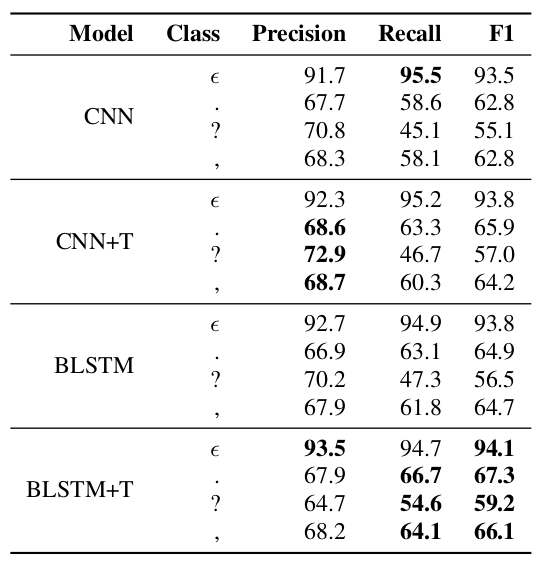

#### 7.2 **LSTM for Punctuation Restoration in Speech Transcripts**

En este segundo artículo [2], los autores presentan un modelo basado en una red neuronal recurrente de dos etapas. Es un artículo previo al del apartado 6, pero de los mismos autores, por lo que se considera interesante de estudiar para seguir la evolución. En su momento fue un modelo nuevo basado en LSTM (*Long short-term memory Networks*) RNN (*Recurrent Neural Networks*). En la primera etapa, se aprenden las características textuales en un gran corpus de textos. En la segunda etapa se combinan las características textuales con la duración de las pausas y se adapta el modelo al dominio del habla. Los autores comentan las ventajas de las LSTM RNN frente a los n-gramas, destacando sus ventajas, como que pueden adaptarse a datos no vistos en el corpus de entrenamiento. Como es un trabajo de 2015, parece ser que esta fue la fecha en la que se empezaron a usar las LSTM frente a los n-gramas.

En este trabajo, al igual que en el anterior, la red también se entrena con información temporal y de puntuación, aunque no solo utilizan un corpus conversacional, si no que también utilizan revistas, prensa, internet, lecturas en voz alta, etc. Los resultados que obtienen los autores se muestran en la siguiente imagen:





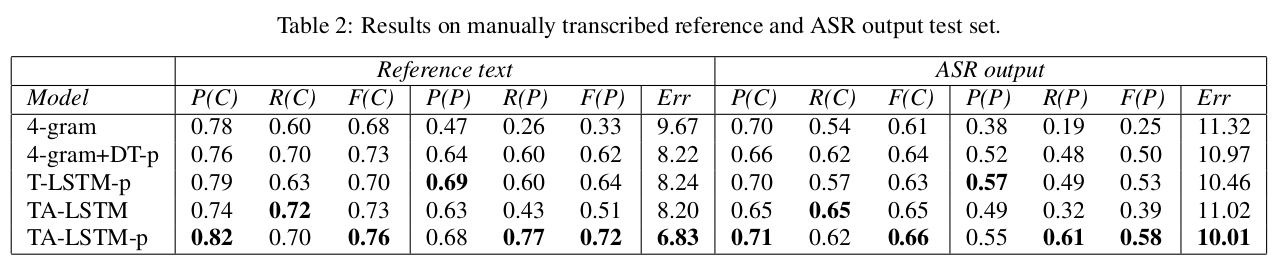

Como puede observarse, son mejores para los LSTM RNN que para los n-gramas. la diferenca entre el prefijo T- y TA- es que el segundo se corresponde con la segunda etapa. EL subíndice p indica que se le ha añadido la información temporal que, en este caso, es la pausa entre palabras.